                                                        Optimal Parameters  \
Gradient Descent         [-0.009868165317309396, -0.003144873651380129,...   
Genetic Algorithm        [-0.009868146270134511, -0.0031448086854145613...   
Simulated Annealing      [-0.009886176197695147, -0.0031299222101011086...   
Trust Region Reflective  [-0.009868155788632422, -0.003144865614072368,...   

                        Minimized Cost         Time (s)  
Gradient Descent              0.090486  N/A (iterative)  
Genetic Algorithm             0.207564         4.762234  
Simulated Annealing           0.207564            0.017  
Trust Region Reflective       0.207564          0.04249  


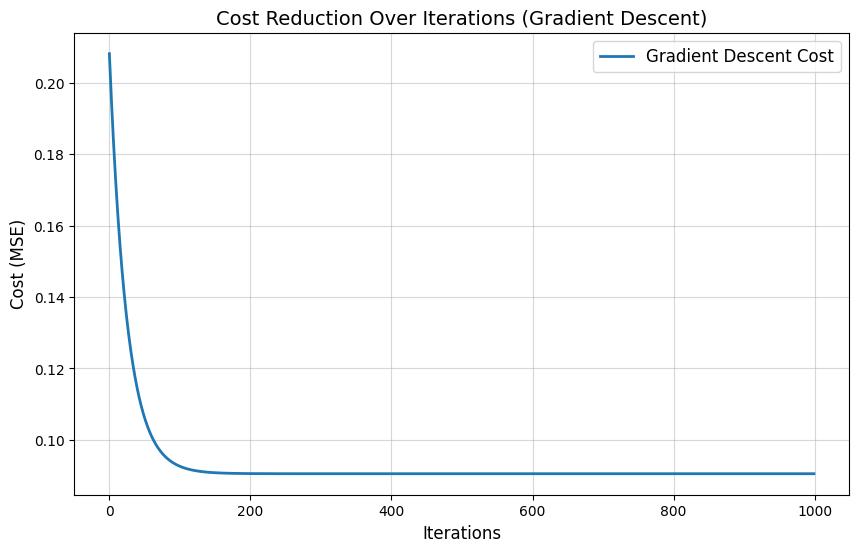

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, differential_evolution
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time

In [ ]:
# Load your dataset
data = pd.read_csv("function_data.csv")  # Replace with your file path

# Separate independent variables (X) and dependent variable (y)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Standardize the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Scale the dependent variable (y) to the range [0, 1]
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

# Objective function for optimization
def objective_function_scaled(params):
    predictions = np.dot(X_scaled, params.reshape(-1, 1))
    mse = np.mean((y_scaled - predictions) ** 2)
    return mse

# Gradient Descent Optimization
def gradient_descent(X, y, learning_rate=0.01, iterations=1000):
    n_samples, n_features = X.shape
    weights = np.zeros((n_features, 1))
    bias = 0
    cost_history = []

    for _ in range(iterations):
        # Predictions
        y_pred = np.dot(X, weights) + bias

        # Compute gradients
        dw = -(2 / n_samples) * np.dot(X.T, (y - y_pred))
        db = -(2 / n_samples) * np.sum(y - y_pred)

        # Update weights and bias
        weights -= learning_rate * dw
        bias -= learning_rate * db

        # Compute the cost (Mean Squared Error)
        cost = np.mean((y - y_pred) ** 2)
        cost_history.append(cost)

    return weights, bias, cost_history


In [ ]:

# Perform Gradient Descent
weights_gd, bias_gd, cost_history_gd = gradient_descent(X_scaled, y_scaled, learning_rate=0.01, iterations=1000)

# Genetic Algorithm Optimization
bounds = [(-10, 10) for _ in range(X_scaled.shape[1])]  # Parameter bounds
start_time = time.time()
ga_result = differential_evolution(objective_function_scaled, bounds, strategy='best1bin', maxiter=1000, tol=1e-7)
ga_time = time.time() - start_time



In [ ]:
# Simulated Annealing (Powell Method)
start_time = time.time()
sa_result = minimize(objective_function_scaled, x0=np.zeros(12), method='Powell', options={'disp': False})
sa_time = time.time() - start_time

# Trust Region Reflective Algorithm
start_time = time.time()
tr_result = minimize(objective_function_scaled, x0=np.zeros(12), method='trust-constr', options={'disp': False})
tr_time = time.time() - start_time

# Results comparison
results = {
    "Gradient Descent": {
        "Optimal Parameters": weights_gd.flatten(),
        "Minimized Cost": cost_history_gd[-1],
        "Time (s)": "N/A (iterative)"
    },
    "Genetic Algorithm": {
        "Optimal Parameters": ga_result.x,
        "Minimized Cost": ga_result.fun,
        "Time (s)": ga_time
    },
    "Simulated Annealing": {
        "Optimal Parameters": sa_result.x,
        "Minimized Cost": sa_result.fun,
        "Time (s)": sa_time
    },
    "Trust Region Reflective": {
        "Optimal Parameters": tr_result.x,
        "Minimized Cost": tr_result.fun,
        "Time (s)": tr_time
    }
}




In [ ]:
results_df = pd.DataFrame(results).T
print(results_df)

# Plot the cost history for Gradient Descent
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(cost_history_gd)), cost_history_gd, label="Gradient Descent Cost", linewidth=2)
plt.title("Cost Reduction Over Iterations (Gradient Descent)", fontsize=14)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Cost (MSE)", fontsize=12)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.metrics import mean_squared_error
import shap

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_scaled, y_scaled)
y_pred_lr = lr_model.predict(X_scaled)
lr_mse = mean_squared_error(y_scaled, y_pred_lr)

# Extract Linear Regression Equation
lr_coefficients = lr_model.coef_.flatten()
lr_intercept = lr_model.intercept_.flatten()[0]
lr_equation = f"y = {lr_intercept:.3f} + " + " + ".join(
    [f"{coef:.3f} * x{i+1}" for i, coef in enumerate(lr_coefficients)]
)

# Decision Tree
dt_model = DecisionTreeRegressor(max_depth=3)  # Restrict depth for simplicity
dt_model.fit(X_scaled, y_scaled)
y_pred_dt = dt_model.predict(X_scaled)
dt_mse = mean_squared_error(y_scaled, y_pred_dt)
dt_rules = export_text(dt_model, feature_names=[f"x{i+1}" for i in range(X_scaled.shape[1])])

# SHAP Analysis for Feature Importance
shap_explainer = shap.Explainer(lr_model, X_scaled)
shap_values = shap_explainer(X_scaled)

# Collect and display results
explainability_results = {
    "Linear Regression": {
        "Equation": lr_equation,
        "MSE": lr_mse
    },
    "Decision Tree": {
        "Rules": dt_rules,
        "MSE": dt_mse
    }
}



In [ ]:
pd.DataFrame(explainability_results)

,Linear Regression,Decision Tree
Equation,y = 0.342 + -0.010 * x1 + -0.003 * x2 + 0.004 ...,NaN
MSE,0.090486,0.0091
Rules,NaN,|--- x2 <= 1.20\n| |--- x2 <= -1.15\n| | ...


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Linear Regression').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Decision Tree').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Decision Tree'].value_counts()
    for x_label, grp in _df_2.groupby('Linear Regression')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Linear Regression')
_ = plt.ylabel('Decision Tree')

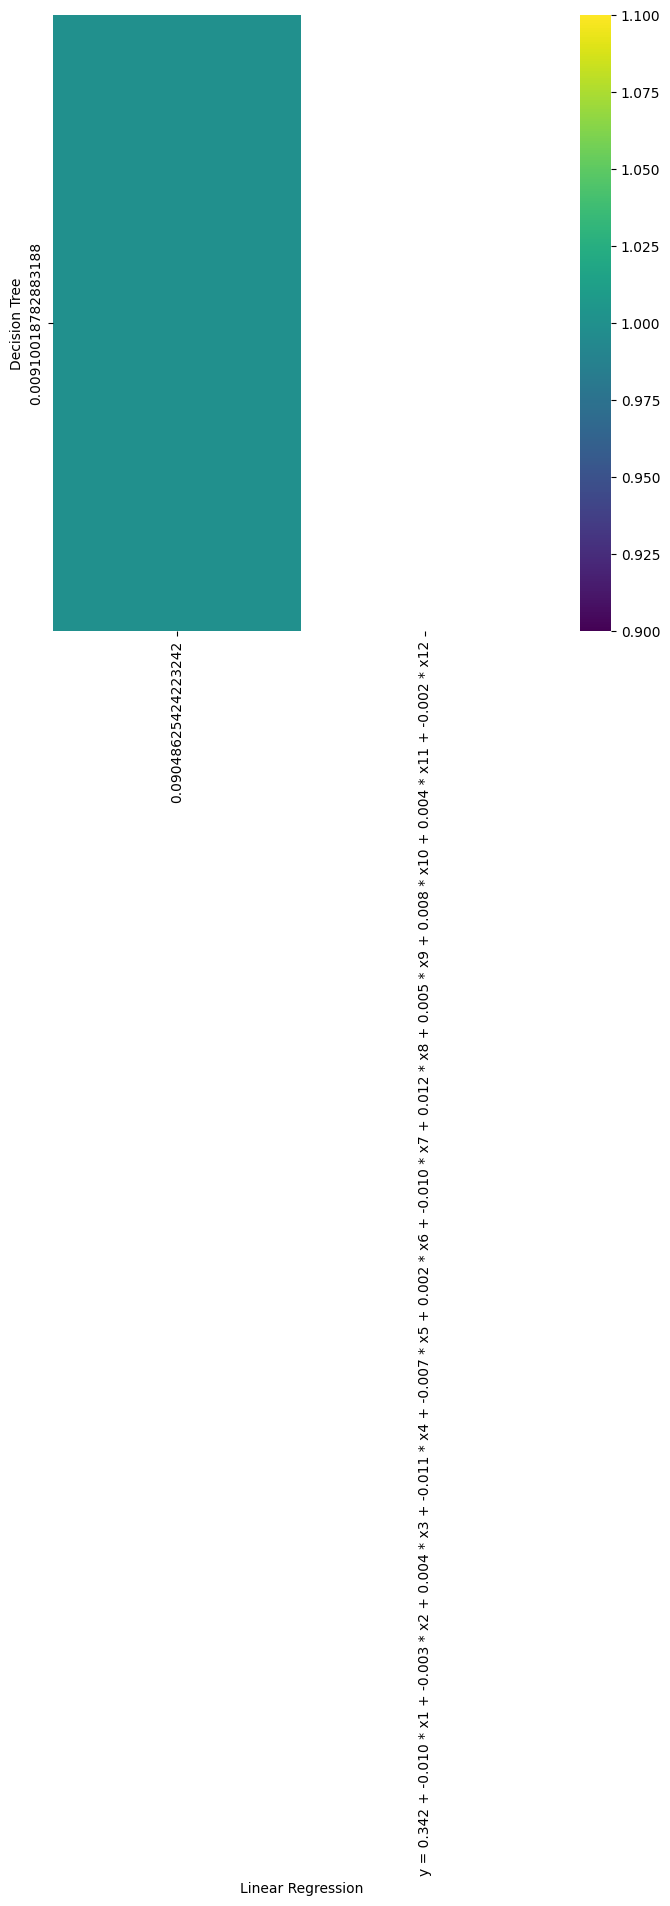

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Decision Tree'].value_counts()
    for x_label, grp in _df_2.groupby('Linear Regression')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Linear Regression')
_ = plt.ylabel('Decision Tree')

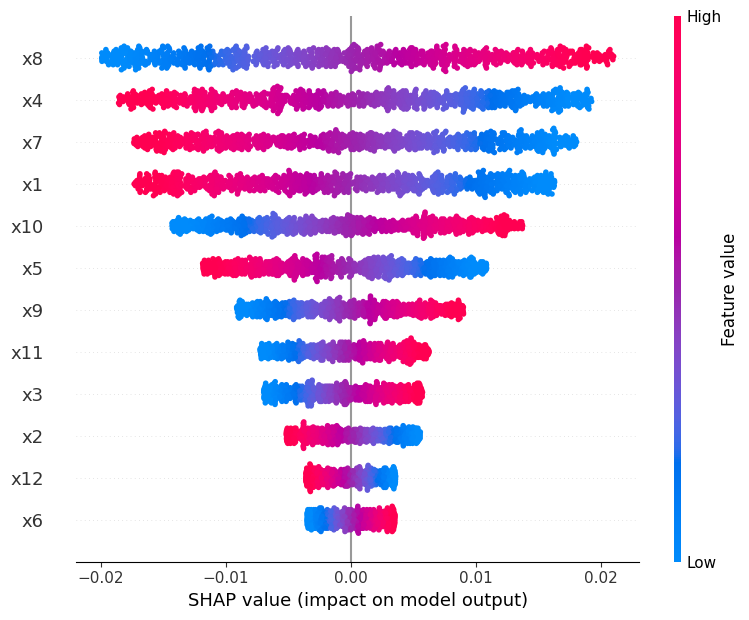

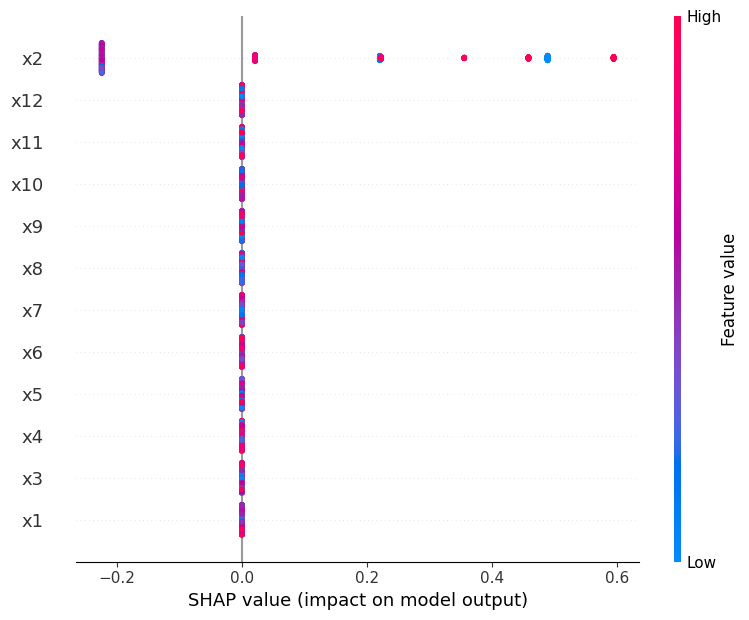

In [ ]:
import shap
import matplotlib.pyplot as plt

# SHAP Analysis for Linear Regression
shap_explainer_lr = shap.Explainer(lr_model, X_scaled)  # Linear Regression
shap_values_lr = shap_explainer_lr(X_scaled)

# Visualize SHAP Summary for Linear Regression
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_lr, X_scaled, feature_names=[f"x{i+1}" for i in range(X_scaled.shape[1])])

# SHAP Analysis for Decision Tree
shap_explainer_dt = shap.TreeExplainer(dt_model)  # Decision Tree
shap_values_dt = shap_explainer_dt(X_scaled)

# Visualize SHAP Summary for Decision Tree
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_dt, X_scaled, feature_names=[f"x{i+1}" for i in range(X_scaled.shape[1])])






In [ ]:
print(f"Base Value: {shap_explainer_lr.expected_value}")
print(f"SHAP Values Shape: {shap_values_lr.shape}")
print(f"Instance Data Shape: {X_scaled[instance_index].shape}")


Base Value: 0.3429687008700653
SHAP Values Shape: (1000, 12)
Instance Data Shape: (12,)


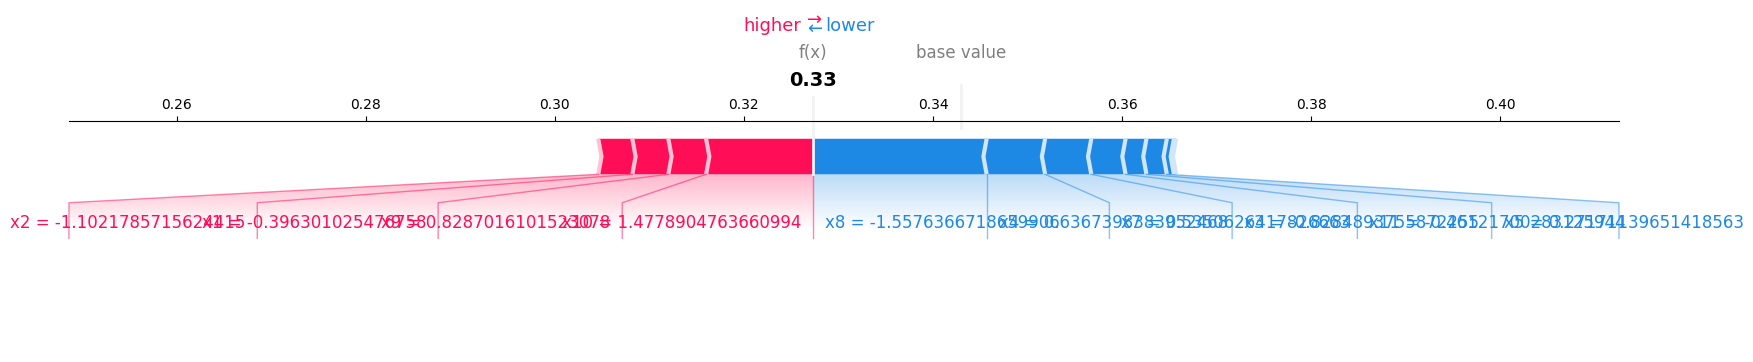

In [ ]:
#  Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_lr[instance_index],         # SHAP values for the instance
    base_values=shap_explainer_lr.expected_value,  # Base value
    data=X_scaled[instance_index],                 # Feature values
    feature_names=[f"x{i+1}" for i in range(X_scaled.shape[1])]
)

# Generate the force plot
shap.force_plot(
    base_value=explanation.base_values,
    shap_values=explanation.values,
    features=explanation.data,
    feature_names=explanation.feature_names,
    matplotlib=True
)


In [ ]:
print(f"SHAP values for instance {instance_index}:")
print(shap_values_lr[instance_index])


SHAP values for instance 0:
.values =
array([ 0.00380558,  0.0036083 , -0.00362774, -0.00618459, -0.00215281,
       -0.00075036, -0.00488051, -0.01833268,  0.00399372,  0.01133729,
       -0.00220877, -0.00023606])

.base_values =
0.3429687008700653

.data =
array([-0.39630103, -1.10217857, -0.82848938,  0.63673984,  0.2717114 ,
       -0.36266703,  0.53506264, -1.55763667,  0.82870161,  1.47789048,
       -0.461217  ,  0.09384064])


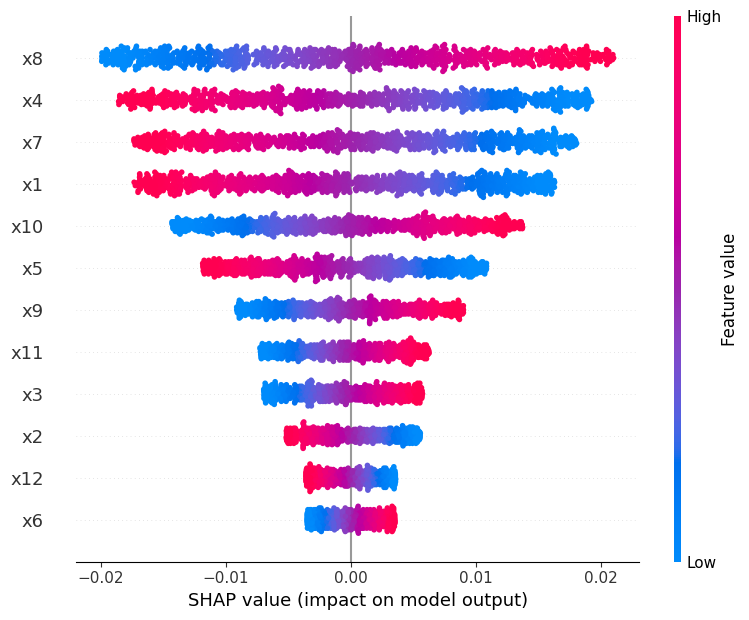

In [ ]:
shap.summary_plot(shap_values_lr, X_scaled, feature_names=[f"x{i+1}" for i in range(X_scaled.shape[1])])


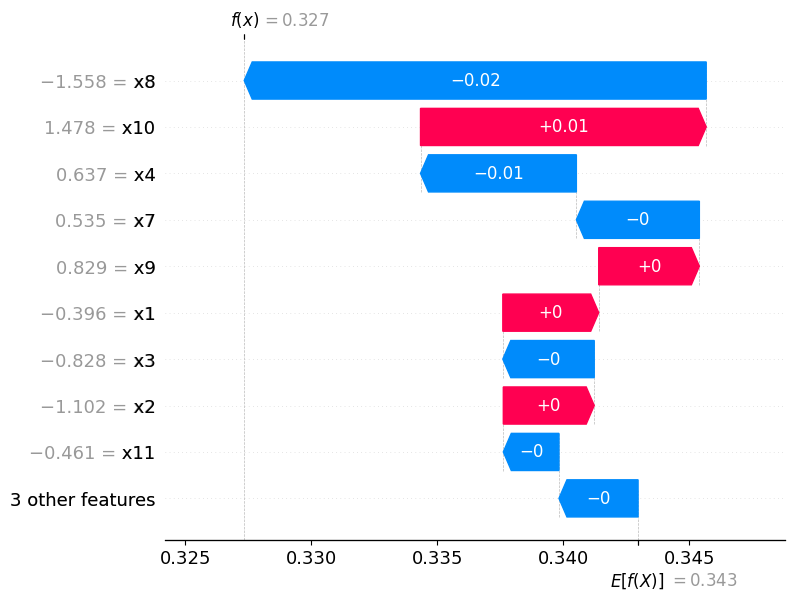

In [ ]:
import shap

# Create SHAP Explanation object for a single instance
instance_index = 0  # Change to explain another instance
explanation = shap.Explanation(
    values=shap_values_lr[instance_index],         # SHAP values for the instance
    base_values=shap_explainer_lr.expected_value,  # Base value
    data=X_scaled[instance_index],                 # Feature values
    feature_names=[f"x{i+1}" for i in range(X_scaled.shape[1])]
)

# Generate the waterfall plot
shap.waterfall_plot(explanation)


In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.preprocessing import MinMaxScaler

# Recreate scaled target variable (y_scaled)
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Fit a Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=3, random_state=42)  # Limiting depth for interpretability
dt_model.fit(X_scaled, y_scaled)

# Extract the rules from the decision tree
tree_rules = export_text(dt_model, feature_names=[f"x{i+1}" for i in range(X_scaled.shape[1])])

# Display the rules
print("Decision Tree Rules:\n")
print(tree_rules)


Decision Tree Rules:

|--- x2 <= 1.20
|   |--- x2 <= -1.15
|   |   |--- x2 <= -1.45
|   |   |   |--- value: [0.83]
|   |   |--- x2 >  -1.45
|   |   |   |--- value: [0.56]
|   |--- x2 >  -1.15
|   |   |--- x2 <= 0.81
|   |   |   |--- value: [0.12]
|   |   |--- x2 >  0.81
|   |   |   |--- value: [0.36]
|--- x2 >  1.20
|   |--- x2 <= 1.45
|   |   |--- x2 <= 1.33
|   |   |   |--- value: [0.56]
|   |   |--- x2 >  1.33
|   |   |   |--- value: [0.70]
|   |--- x2 >  1.45
|   |   |--- x2 <= 1.57
|   |   |   |--- value: [0.80]
|   |   |--- x2 >  1.57
|   |   |   |--- value: [0.94]



In [ ]:
# Adjust the export_text to view the full tree
tree_rules = export_text(
    dt_model,
    feature_names=[f"x{i+1}" for i in range(X_scaled.shape[1])],
    max_depth=10  # Increase if necessary
)
print(tree_rules)
# Save the rules to a file
with open("decision_tree_rules.txt", "w") as file:
    file.write(tree_rules)

print("Decision Tree Rules saved to 'decision_tree_rules.txt'")


|--- x2 <= 1.20
|   |--- x2 <= -1.15
|   |   |--- x2 <= -1.45
|   |   |   |--- value: [0.83]
|   |   |--- x2 >  -1.45
|   |   |   |--- value: [0.56]
|   |--- x2 >  -1.15
|   |   |--- x2 <= 0.81
|   |   |   |--- value: [0.12]
|   |   |--- x2 >  0.81
|   |   |   |--- value: [0.36]
|--- x2 >  1.20
|   |--- x2 <= 1.45
|   |   |--- x2 <= 1.33
|   |   |   |--- value: [0.56]
|   |   |--- x2 >  1.33
|   |   |   |--- value: [0.70]
|   |--- x2 >  1.45
|   |   |--- x2 <= 1.57
|   |   |   |--- value: [0.80]
|   |   |--- x2 >  1.57
|   |   |   |--- value: [0.94]

Decision Tree Rules saved to 'decision_tree_rules.txt'


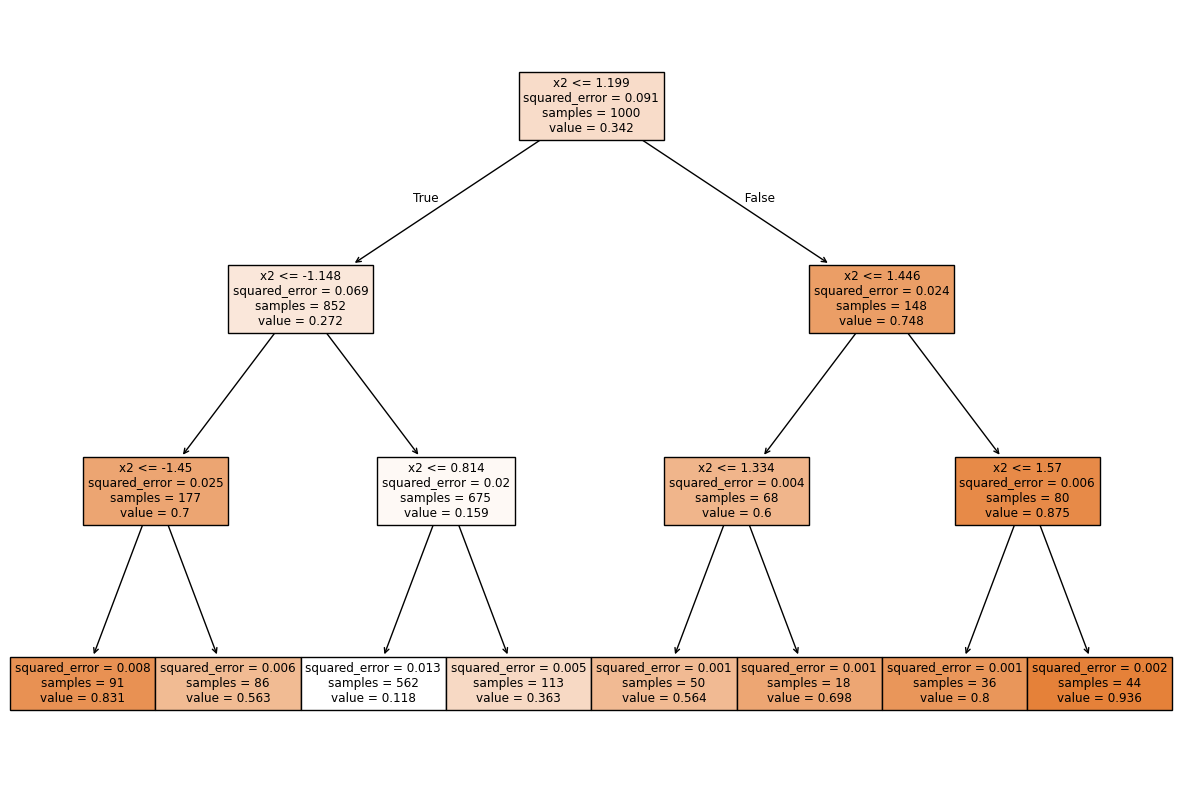

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize the decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt_model, feature_names=[f"x{i+1}" for i in range(X_scaled.shape[1])], filled=True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Refit the Decision Tree model
dt_model = DecisionTreeRegressor(max_depth=3, random_state=42)  # Limiting depth for interpretability
dt_model.fit(X_scaled, y_scaled)

# Refit the Linear Regression model if needed (though it should already be trained)
lr_model.fit(X_scaled, y_scaled)

# Predict using the Decision Tree model
y_pred_dt = dt_model.predict(X_scaled)

# Calculate accuracy metrics for the Decision Tree model
dt_mse = mean_squared_error(y_scaled, y_pred_dt)
dt_r2 = r2_score(y_scaled, y_pred_dt)

# Predict using the Linear Regression model
y_pred_lr = lr_model.predict(X_scaled)

# Calculate accuracy metrics for the Linear Regression model
lr_mse = mean_squared_error(y_scaled, y_pred_lr)
lr_r2 = r2_score(y_scaled, y_pred_lr)

# Display the results
accuracy_results = {
    "Model": ["Decision Tree", "Linear Regression"],
    "MSE": [dt_mse, lr_mse],
    "R2 Score": [dt_r2, lr_r2]
}

import pandas as pd
accuracy_df = pd.DataFrame(accuracy_results)



In [ ]:
print("Model Accuracy Comparison:")
print(accuracy_df)

Model Accuracy Comparison:
               Model       MSE  R2 Score
0      Decision Tree  0.009100  0.900104
1  Linear Regression  0.090486  0.006704


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Fit an XGBoost model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train.ravel())

# Predict using the XGBoost model
y_pred_xgb = xgb_model.predict(X_test)

# Calculate accuracy metrics for the XGBoost model
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)

# Display the results
print("XGBoost Model Accuracy:")
print(f"Mean Squared Error (MSE): {xgb_mse}")
print(f"R2 Score: {xgb_r2}")


XGBoost Model Accuracy:
Mean Squared Error (MSE): 3.7624242836409765e-05
R2 Score: 0.9995651720779999


<Figure size 1000x800 with 0 Axes>

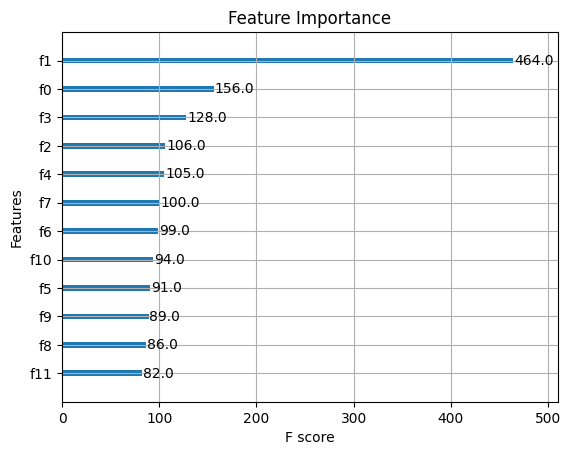

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=12)  # Show top 10 features
plt.title("Feature Importance")
plt.show()


Generating SHAP Summary Plot...


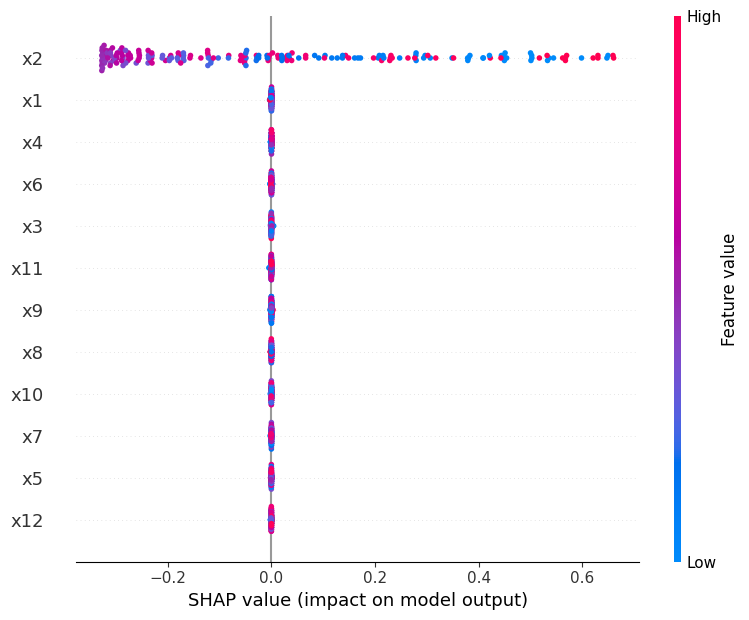

Generating SHAP Force Plot for Instance...


In [ ]:
import shap

# Create SHAP explainer for XGBoost model
shap_explainer_xgb = shap.Explainer(xgb_model, X_train)

# Calculate SHAP values for the test data
shap_values_xgb = shap_explainer_xgb(X_test)

# 1. SHAP Summary Plot
print("Generating SHAP Summary Plot...")
shap.summary_plot(shap_values_xgb, X_test, feature_names=[f"x{i+1}" for i in range(X_train.shape[1])])





In [ ]:
import shap

# Create SHAP Explainer for XGBoost
shap_explainer_xgb = shap.TreeExplainer(xgb_model)  # Use TreeExplainer for XGBoost
shap_values_xgb = shap_explainer_xgb.shap_values(X_test)  # Calculate SHAP values

# Ensure feature names are defined
feature_names = [f"x{i+1}" for i in range(X_train.shape[1])]
# Use the expected value, SHAP values, and input data
shap.force_plot(
    base_value=shap_explainer_xgb.expected_value,
    shap_values=shap_values_xgb[:1000, :],  # First 1000 instances
    features=X_test[:1000, :],              # Corresponding input data
    feature_names=feature_names
)


In [ ]:
# orce plot for multiple instances
force_plot = shap.force_plot(
    base_value=shap_explainer_xgb.expected_value,
    shap_values=shap_values_xgb[:1000, :],  # First 1000 instances
    features=X_test[:1000, :],              # Corresponding input data
    feature_names=[f"x{i+1}" for i in range(X_train.shape[1])]
)

# Save the interactive force plot as an HTML file
shap.save_html("shap_force_plot.html", force_plot)

print("Force plot saved as 'shap_force_plot.html'. Open it in a browser to view.")


Force plot saved as 'shap_force_plot.html'. Open it in a browser to view.


In [ ]:
# Generate the force plot for multiple instances (e.g., first 10 instances)
force_plot = shap.force_plot(
    base_value=shap_explainer_xgb.expected_value,
    shap_values=shap_values_xgb[:10],  # First 10 instances
    features=X_test[:10],              # Corresponding input data
    feature_names=[f"x{i+1}" for i in range(X_train.shape[1])]
)

# Save the interactive force plot as HTML
shap.save_html("interactive_force_plot.html", force_plot)
print("Force plot saved as 'interactive_force_plot.html'. Open it in a browser to view.")


Force plot saved as 'interactive_force_plot.html'. Open it in a browser to view.


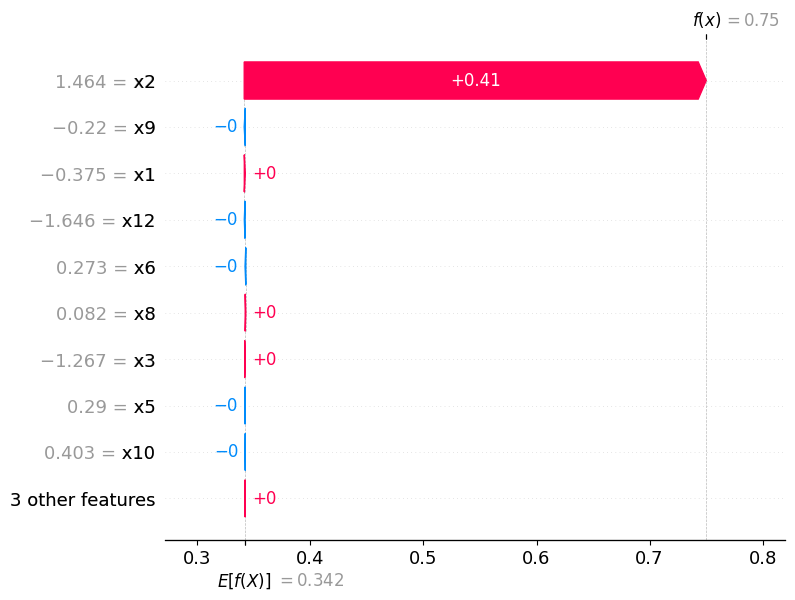

In [ ]:
import shap

# Ensure the SHAP explainer and values are calculated
shap_explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = shap_explainer_xgb.shap_values(X_test)

# Generate SHAP Waterfall Plot for a single instance
instance_index = 0  # Change this to view a different instance

# Create SHAP Explanation object for the selected instance
explanation = shap.Explanation(
    values=shap_values_xgb[instance_index],         # SHAP values for the instance
    base_values=shap_explainer_xgb.expected_value,  # Base value
    data=X_test[instance_index],                    # Feature values for the instance
    feature_names=[f"x{i+1}" for i in range(X_train.shape[1])]
)

# Generate the waterfall plot
shap.waterfall_plot(explanation)
